In [1]:
import pandas as pd
from seabird.cnv import fCNV
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from scipy.interpolate import griddata
from cmocean import cm as cmo
import gsw

In [2]:
#fCNV(files[0]).keys()

In [3]:
max_z = 100
lat = 57
lon = 11

files = sorted(glob('*.cnv')) # add your path here

z = np.arange(0, max_z, 0.2)

temp_grid = np.ndarray([np.size(z), np.size(files)])
sal_grid = np.ndarray([np.size(z), np.size(files)])
rho_grid = np.ndarray([np.size(z), np.size(files)])

for i, fname in enumerate(files):
    
    ctd_cast = fCNV(fname)
    
    sal_cast  = gsw.SA_from_SP(ctd_cast['PSAL'],ctd_cast['PRES'],lon,lat).data
    temp_cast  = gsw.CT_from_t(sal_cast,ctd_cast['TEMP'],ctd_cast['PRES']).data  
    rho_cast = gsw.rho(sal_cast,temp_cast,ctd_cast['PRES']).data  
    depth_cast = ctd_cast['DEPTH'].data
    
    temp_grid[:,i] = griddata(depth_cast, temp_cast, z)
    sal_grid[:,i] = griddata(depth_cast, sal_cast, z)
    rho_grid[:,i] = griddata(depth_cast, rho_cast, z)

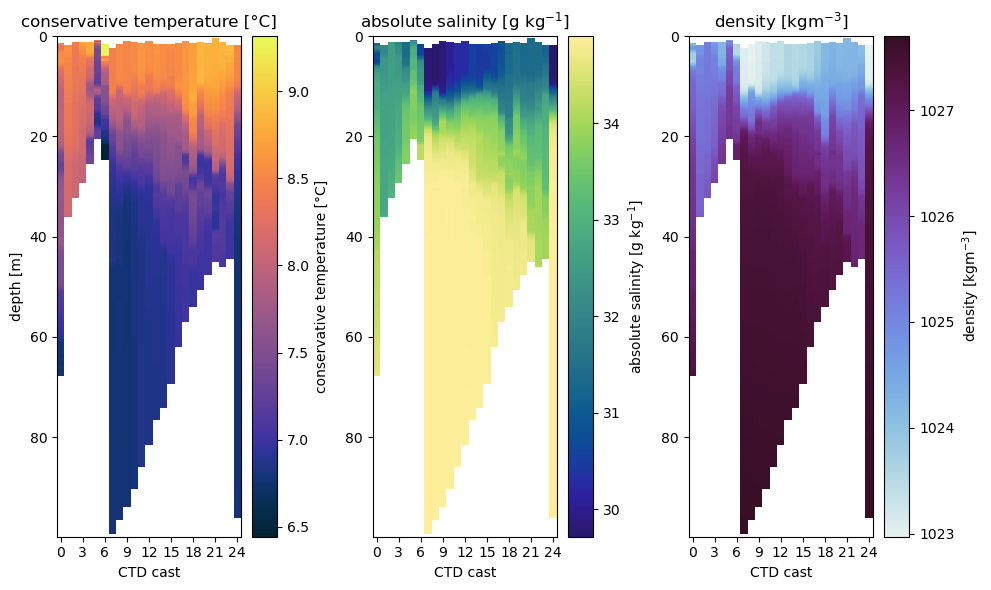

In [4]:
fig, ax = plt.subplots(figsize=[10,6], ncols=3)

fig1 = ax[0].pcolormesh(np.arange(np.size(files)), z, temp_grid, cmap=cmo.thermal)
ax[0].invert_yaxis()
cb1 = plt.colorbar(fig1 , ax=ax[0], label='conservative temperature [°C]')
ax[0].set_xticks(np.arange(0,25,3))
ax[0].set(title='conservative temperature [°C]', xlabel='CTD cast', ylabel='depth [m]')

fig2 = ax[1].pcolormesh(np.arange(np.size(files)), z, sal_grid, cmap=cmo.haline)
ax[1].invert_yaxis()
cb2 = plt.colorbar(fig2 , ax=ax[1], label='absolute salinity [g kg$^{-1}$]')
ax[1].set_xticks(np.arange(0,25,3))
ax[1].set(title='absolute salinity [g kg$^{-1}$]', xlabel='CTD cast', ylabel=None)

fig3 = ax[2].pcolormesh(np.arange(np.size(files)), z, rho_grid, cmap=cmo.dense)
ax[2].invert_yaxis()
cb3 = plt.colorbar(fig3 , ax=ax[2], label='density [kgm$^{-3}$]')
ax[2].set_xticks(np.arange(0,25,3))
ax[2].set(title='density [kgm$^{-3}$]', xlabel='CTD cast', ylabel=None)

plt.tight_layout()
plt.show()

In [31]:
ref_depth = 5 # choose some depth as the reference depth
idx = np.argmin(np.abs((z - ref_depth))) # finds the index of 'z' where the depth == ref_depth

mld= []

for j in range(0,len(files)):
    
    for k in range(0,len(rho_grid)+1-idx):
        
        if abs(rho_grid[idx,j] - rho_grid[idx+k,j]) >= 0.03:
            mld.append(z[idx+k])

            break 
            
        else:
            continue

# OBS some casts don't have a mld!!

In [19]:
labels = ['ctd_001','ctd_002','ctd_003','ctd_004','ctd_005','ctd_006','ctd_007',
         'ctd_101','ctd_102','ctd_103','ctd_104','ctd_105','ctd_106','ctd_107',
         'ctd_108','ctd_109','ctd_110','ctd_111','ctd_112','ctd_113','ctd_114',
         'ctd_115','ctd_116','ctd_117','ctd_yoyo_001']

In [20]:


for i in range(np.size(files)):
    
    fig, ax = plt.subplots(figsize=[10,6], ncols=3)
    
    ax[0].plot(temp_grid[:,i], z, label = labels[i])
    ax[0].invert_yaxis()
    ax[0].legend()
    
    ax[1].plot(sal_grid[:,i], z, label = labels[i])
    ax[1].invert_yaxis()
    ax[1].legend()
    
    ax[2].plot(rho_grid[:,i], z, label = labels[i])
    ax[2].invert_yaxis()
    ax[2].legend()
    
    for a in ax:
        a.axhline(mld[i], c='k', ls='--')
        a.set_ylim(100,0)
        a.yaxis.set_ticks(np.arange(0, 110, 10))
        
    ax[0].set(title='temperature [°C]', ylabel='depth [m]')
    ax[1].set(title='salinity [psu]')
    ax[2].set(title='potential density [kgm$^{-3}$]')
        
    plt.savefig('/Users/lovisaholmquist/Desktop/ctd_mld_' + str(labels[i]) + '.png') # Change path to your own
    
    plt.close()

    
#ax[0].set(title='temperature [°C]', ylabel='depth [m]')
#ax[1].set(title='salinity [psu]')
#ax[2].set(title='potential density [kgm$^{-3}$]')

#plt.show()

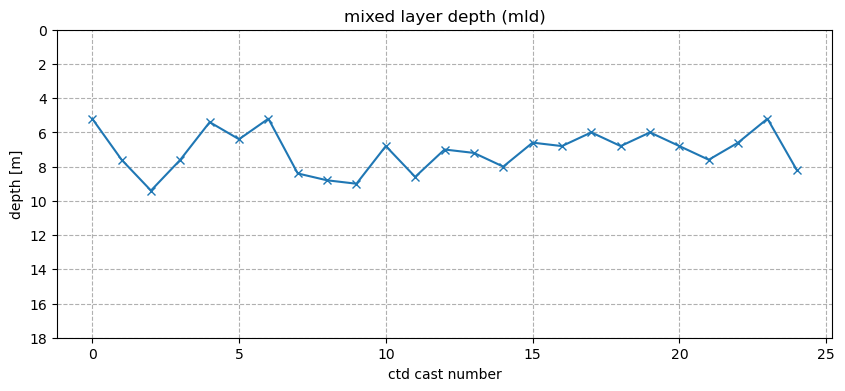

In [30]:
fig, ax = plt.subplots(figsize=[10,4])

plt.plot(np.arange(np.size(files)), mld, '-x')
ax.invert_yaxis()
ax.grid(linestyle='--')
ax.set_yticks(np.arange(0,20,2))

ax.set(title='mixed layer depth (mld)', ylabel='depth [m]', xlabel='ctd cast number')

plt.show()